# Customer Segmentation with Clustering

Using unsupervised machine learning to identify distinct groups of customers within a mall's dataset.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv(r"/content/Mall_Customers.csv")

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## EDA

In [4]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

### Univariate Analysis (Feature Distributions)

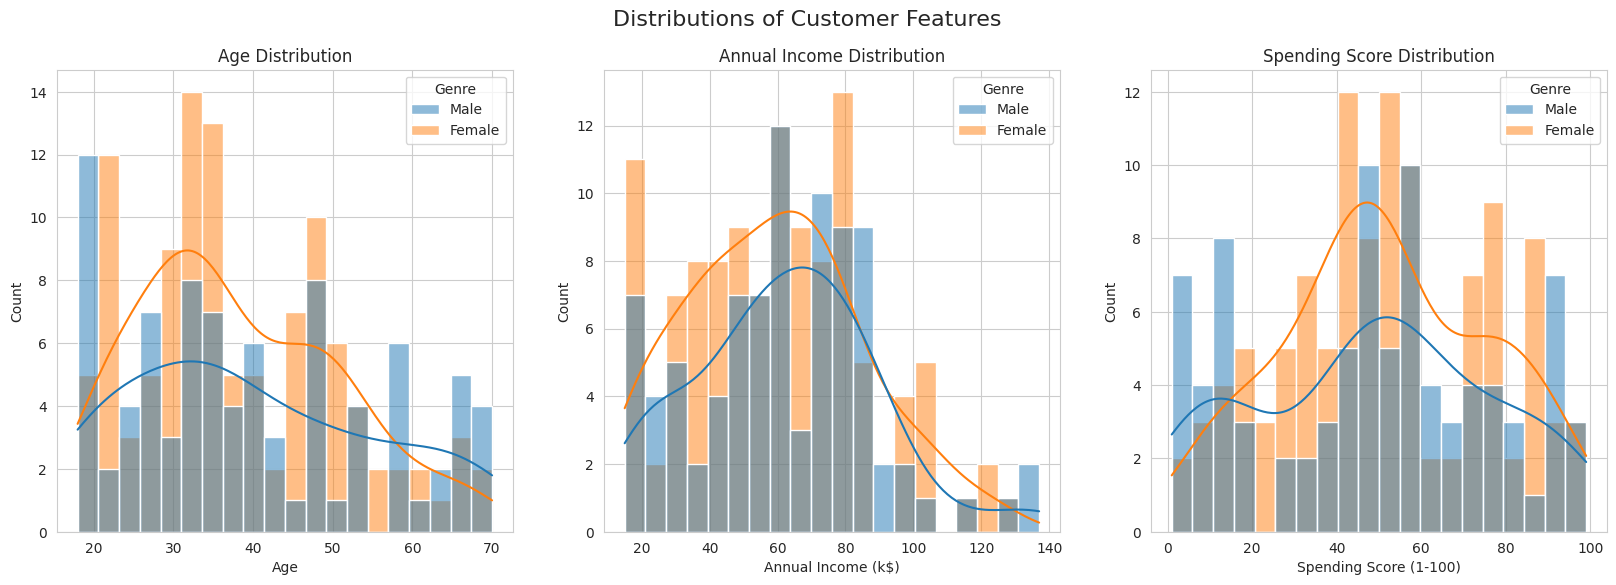

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Genre').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Genre').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Genre').set_title('Spending Score Distribution')

plt.show()

### Bivariate Analysis

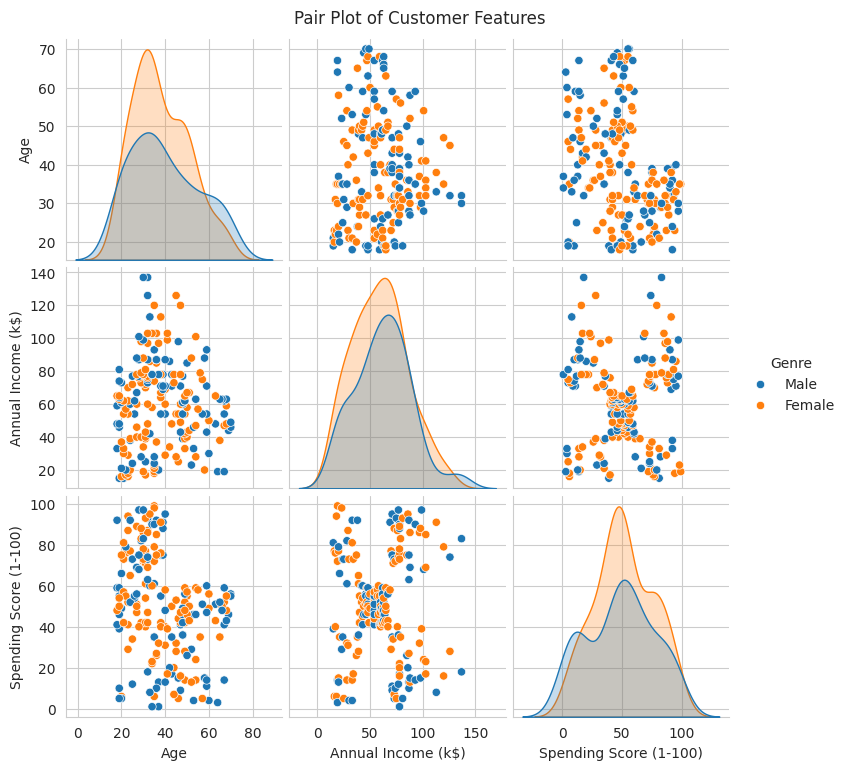

In [8]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Genre', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

**Observations:**
- `Annual income` vs `spending score`: shows distinct groups
- `age` vs `spending score`: high-spending customers in younger age brackets
- `gender`: largly overlaps (not a strong seperating feature)

In [10]:
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Genre',
                    title='3D View of Customer Data')
fig.show()

## Segmentation Model 1 - Income & Spending Score

- The Elbow Method used for choosing the number of cluseters to choose for the data.
- Calculates **Within-Cluster Sum of Squares (WCSS)** for different values of `k`.
- WCSS is the sum of the squared distances between each point and the centroid of the cluster it belongs to.

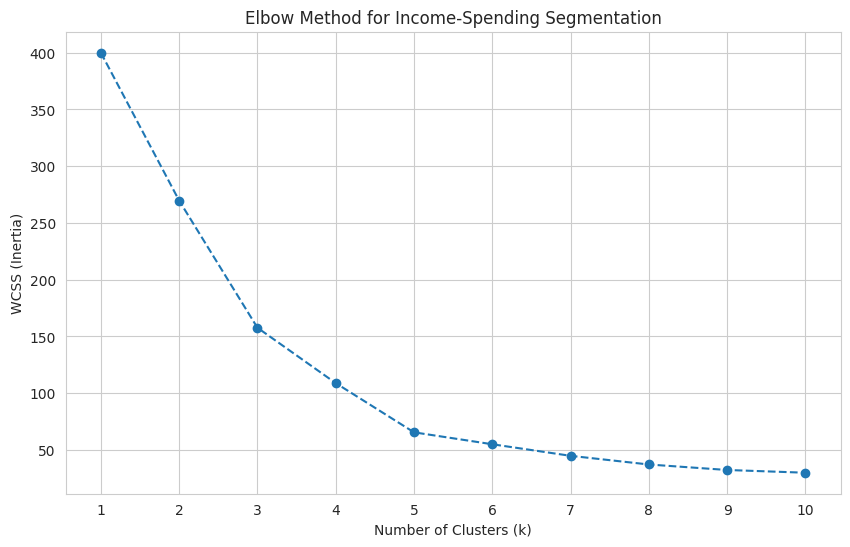

In [11]:
# 1. Select and scale the features
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The "elbow" of the curve is at **k=5**. (The WCSS decreases sharply until k=5, and then the rate of decrease flattens out)

In [12]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

## Segmentation model 1 - Visualizing the income vs spending score

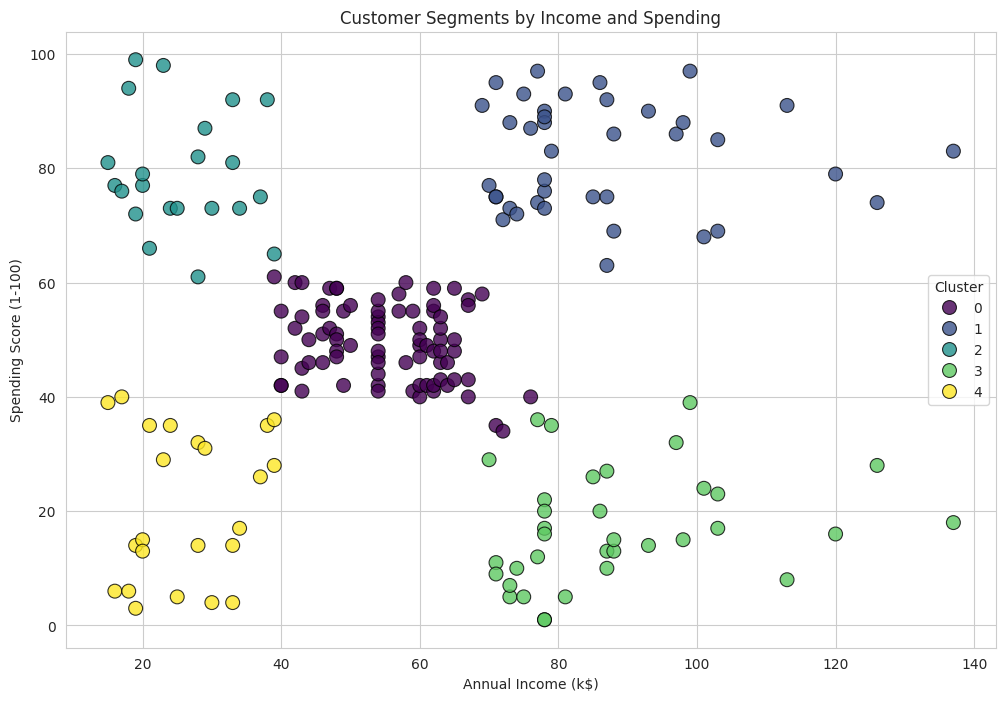

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [14]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


### **Insights:**

Segments observed:
- **Cluster 0 (Careful High-Earners):** High income (~88k) but low spending (~17). Cautious, value-driven buyers.

- **Cluster 1 (Standard):** Average income (~55k) and spending (~50). This is the largest, core customer group.

- **Cluster 2 (Budget Shoppers):** Low income (~26k) and low spending (~21). Highly price-sensitive.

- **Cluster 3 (Target - High Value):** High income (~87k) and high spending (~82). The mall's prime target.

- **Cluster 4 (Enthusiasts):** Low income (~26k) but high spending (~79). Likely young, trend-focused shoppers.

## Segmentation Model 2 - Age & Spending Score

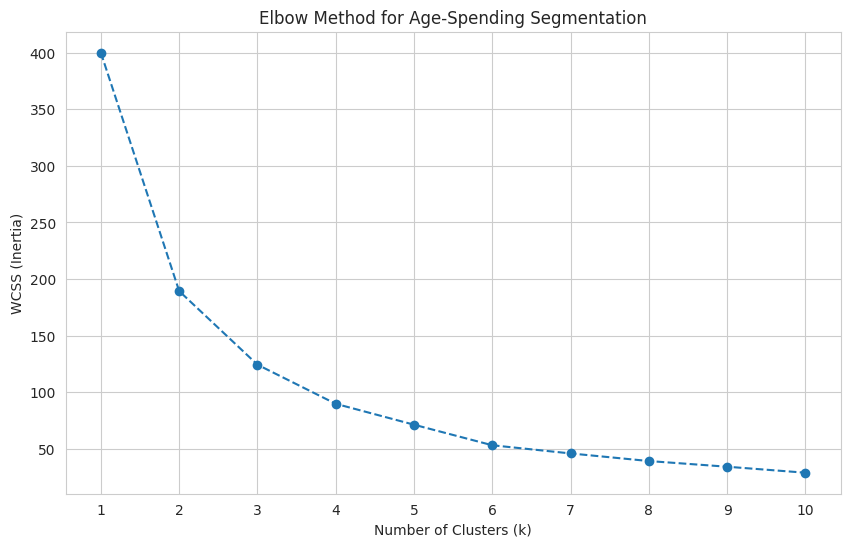

In [15]:
# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** k=4 appears to be a reasonable choice.

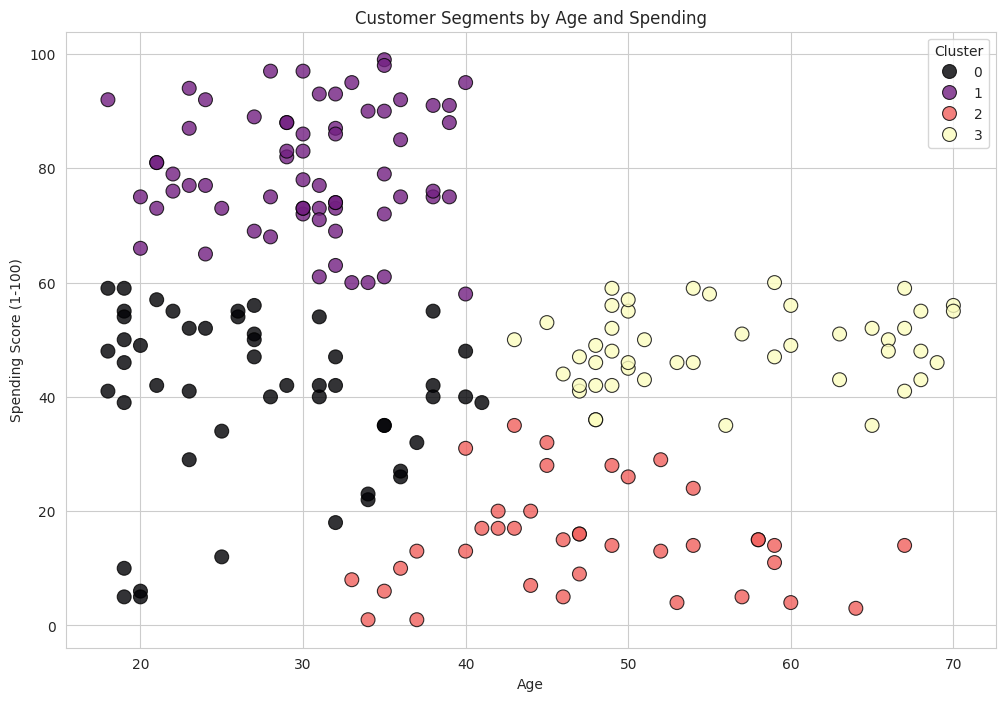

In [16]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

**Insights:**

- **Young High-Spenders:** A clear group of customers under 40 with high spending scores.

- **Young Low-Spenders:** Customers under 40 with low-to-moderate spending.

- **Older Low-Spenders:** A small group of older customers with very low spending scores.

- **Older Average-Spenders:** Customers over 40 with moderate spending scores.


## **Hierarchical Clustering**

- Unlike K-Means, doesn't require us to specify the number of clusters beforehand.
- It builds a tree-like hierarchy of clusters.
- The dendrogram shows how clusters are merged.

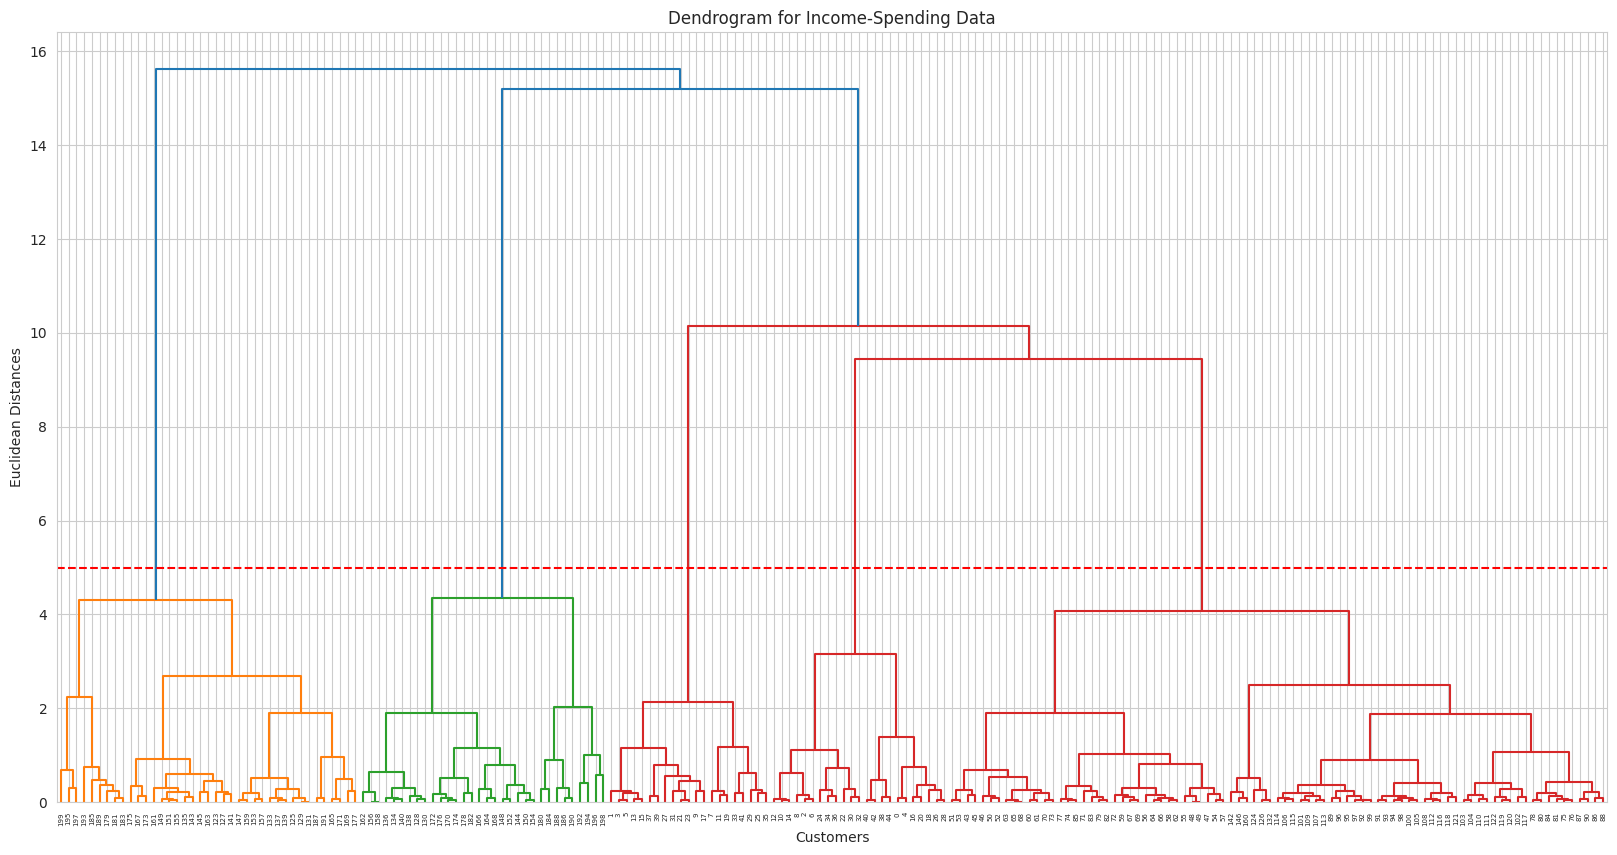

In [17]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=5, color='r', linestyle='--') # Example cut-off line
plt.show()

To find the optimal number of clusters:
- In the dendrogram, look at the vertical lines where clusters join.
- Find the place where there’s the biggest vertical gap before the next merge.
- That gap shows a natural separation: Draw a horizontal cut across dendrogram at that height.
- Count number of intersections the horizontal line makes with the vertical line.

**FROM ABOVE:**
- 5 clusters are optimal

## Segmentation Model 3 - Gender vs Spending Score

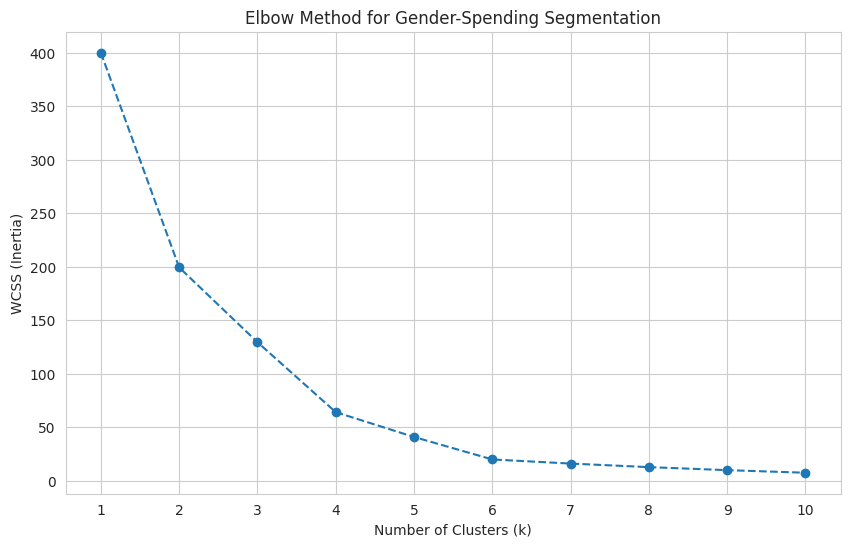

In [20]:
# 1. Select the features and handle categorical variable (Gender)
X3 = df[['Genre', 'Spending Score (1-100)']]
X3 = pd.get_dummies(X3, columns=['Genre'], drop_first=True) # One-hot encode Gender

# 2. Scale the features
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

# 3. Implement the Elbow Method
wcss3 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X3_scaled)
    wcss3.append(kmeans.inertia_)

# 4. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss3, marker='o', linestyle='--')
plt.title('Elbow Method for Genre-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

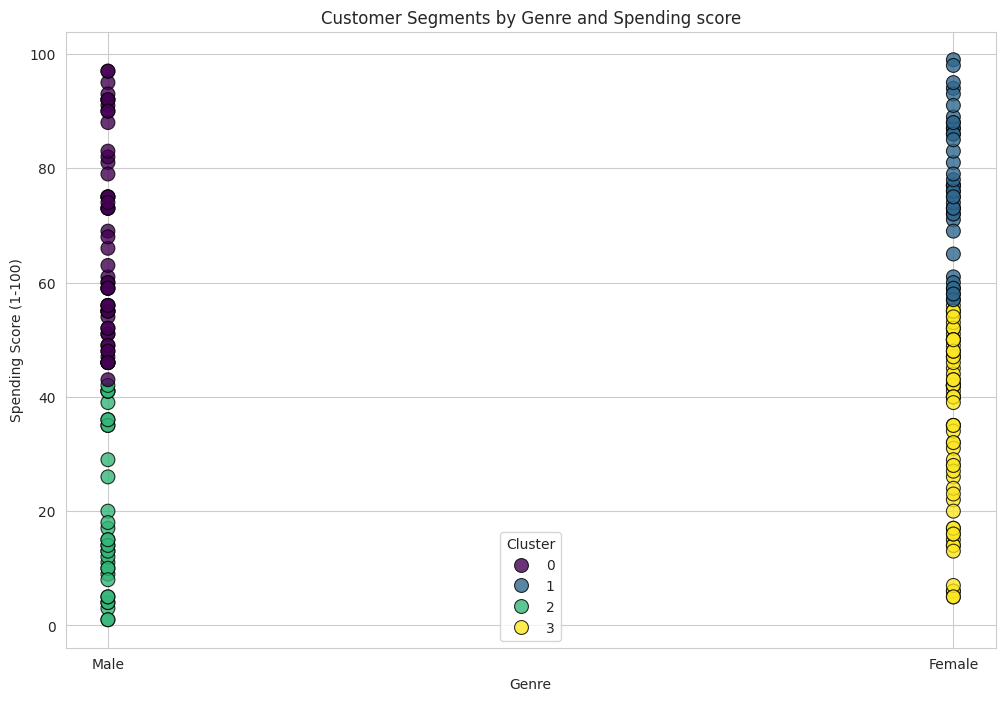

In [21]:
# Build and fit the final model for gender segmentation
kmeans3 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Genre_Cluster'] = kmeans3.fit_predict(X3_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Genre', y='Spending Score (1-100)',
                hue='Genre_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Genre and Spending score')
plt.legend(title='Cluster')
plt.show()

**Observations:**
- There are High and low spending clusters for both genders
- The spending score for females are generally higher
- A higher spread is seen for male customers who spend more

## A little extra Model:

Propensity: the total consumption/ income of customer

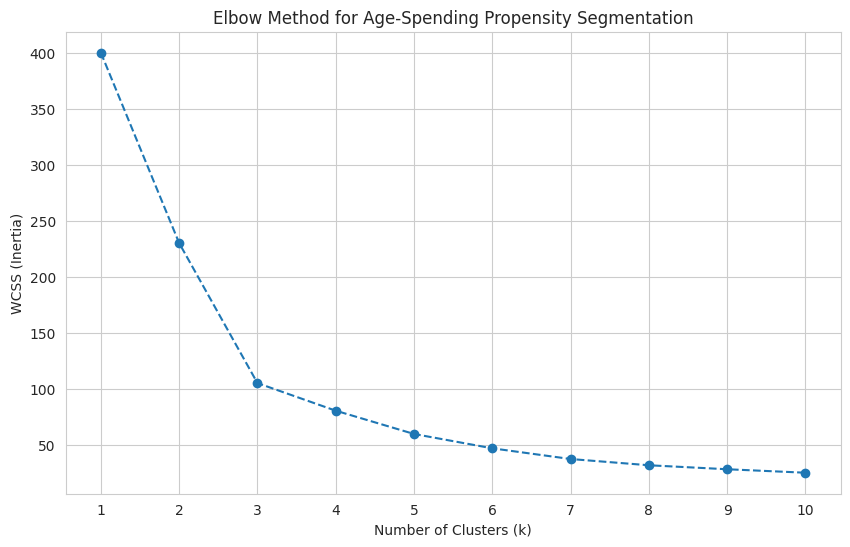

In [22]:
 df['Spending_Propensity'] = df['Spending Score (1-100)'] / (df['Annual Income (k$)'] + 1e-6)

X5 = df[['Age', 'Spending_Propensity']]

scaler5 = StandardScaler()
X5_scaled = scaler5.fit_transform(X5)

wcss5 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X5_scaled)
    wcss5.append(kmeans.inertia_)

# 5. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss5, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Propensity Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

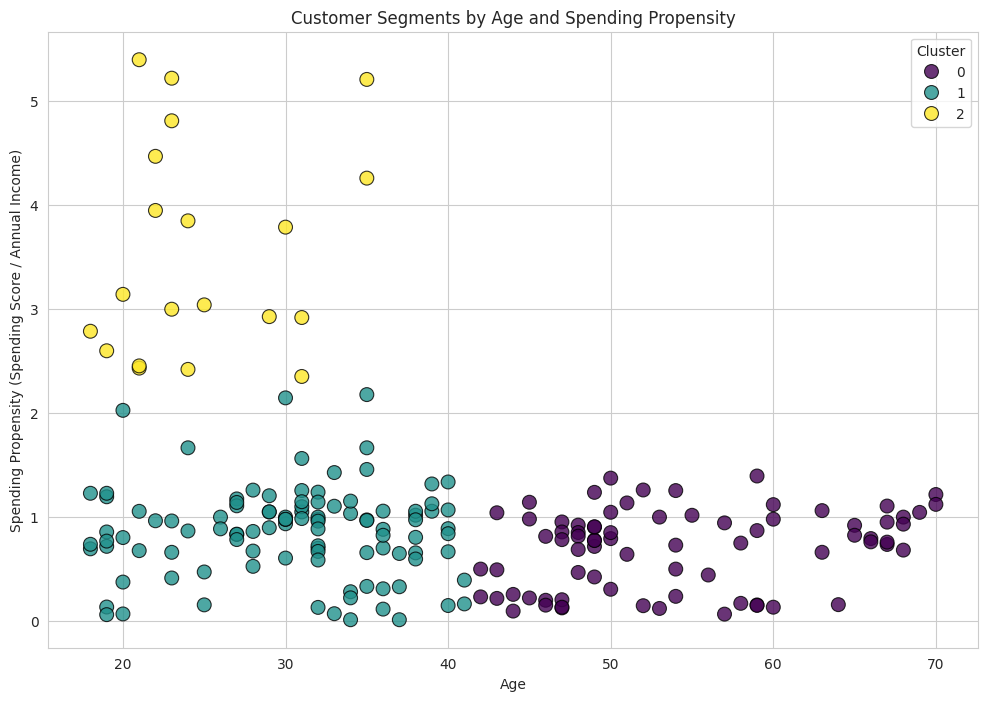

In [23]:
# Build and fit the final model for age-spending propensity segmentation
kmeans5 = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
df['Age_Spending_Propensity_Cluster'] = kmeans5.fit_predict(X5_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending_Propensity',
                hue='Age_Spending_Propensity_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending Propensity')
plt.xlabel('Age')
plt.ylabel('Spending Propensity (Spending Score / Annual Income)')
plt.legend(title='Cluster')
plt.show()

**Observations:**
- There are 3 distinct clusters that are formed
- Younger high propensity customers
- Younger low propensity customers
- Older low propensity customers